In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score, confusion_matrix
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
def plot_data(data_dict, ax=None):
    cmap = "coolwarm"
    od_color = "black"

    # Use the provided ax or create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()

    # Plot anchor points colored by class labels
    if "anchor" in data_dict:
        anchor_X, anchor_y = data_dict["anchor"]
        assert anchor_X.shape[1] == 2, "Anchor data must be 2-dimensional"
        ax.scatter(anchor_X[:, 0], anchor_X[:, 1], c=anchor_y, cmap=cmap, label="Anchor")

    if "ID" in data_dict:
        id_X, id_y = data_dict["ID"]
        assert id_X.shape[1] == 2, "ID data must be 2-dimensional"
        # Plot in-distribution (ID) data points with lighter color
        ax.scatter(id_X[:, 0], id_X[:, 1], c=id_y, cmap=cmap, alpha=0.5, label="In-Distribution")

    if "OD" in data_dict:
        od_X, od_y = data_dict["OD"]
        assert od_X.shape[1] == 2, "OD data must be 2-dimensional"
        # Plot OD data points with distinct color
        ax.scatter(od_X[:, 0], od_X[:, 1], c=od_color, label="Out-of-Distribution",
                   alpha=0.5)

    ax.legend()

    # Only call plt.show() if ax was not provided
    if ax is None:
        plt.show()

In [23]:
@torch.inference_mode()
def contrastive_transform(net, task, X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(net.device)
    return net.contrastive_embedding(X, task).detach().cpu().numpy()

In [24]:
def apply_transform_to_data_dict(data_dict, transform=None):
    """
    Applies a transformation function to the X component of each dataset in the data_dict.

    :param data_dict: Dictionary containing datasets. Each key corresponds to a dataset name,
                      and each value is a tuple (X, y) where X is the data to transform.
    :param transform: A function that applies a transformation to X.
    :return: A new data_dict with transformed X components.
    """
    transformed_data_dict = {}
    if transform is None:
        transform = lambda x: x

    for key, (X, y) in data_dict.items():
        # Apply the transform function to X
        transformed_X = transform(X)

        # Update the dataset in the new dictionary
        transformed_data_dict[key] = (transformed_X, y)

    return transformed_data_dict

In [6]:
def combined_tsne_transform(data_dict, n_components=2, random_state=42):
    """
    Applies t-SNE to reduce the dimensions of the combined image data from all subsets
    (OD, ID, anchor) to ensure they are mapped to the same space.

    :param data_dict: Dictionary containing OD, ID, and anchor datasets.
                      Each value should be a tuple (X, y).
    :param n_components: The number of dimensions to reduce to (default is 2).
    :param random_state: Random state for reproducibility (optional).
    :return: Dictionary with transformed data for each subset.
    """
    # Combine all subsets into one dataset for fitting t-SNE
    combined_X = np.concatenate([X.reshape(X.shape[0], -1) for X, _ in data_dict.values()], axis=0)

    # Fit t-SNE on the combined dataset
    tsne = TSNE(n_components=n_components, random_state=random_state)
    combined_X_transformed = tsne.fit_transform(combined_X)

    # Split the transformed data back into the respective subsets
    transformed_data_dict = {}
    start_idx = 0
    for key, (X, y) in data_dict.items():
        end_idx = start_idx + X.shape[0]
        transformed_data_dict[key] = (combined_X_transformed[start_idx:end_idx, :], y)
        start_idx = end_idx

    return transformed_data_dict

In [7]:
def plot_scores(data_dict, computer, ax=None):
    """
    Produces a histogram plot for the given data_dict, showing the distribution of scores.
    :param data_dict: Dictionary with keys 'anchor', 'ID', and 'OD'.
    :param computer: Function that computes the scores.
    :param ax: Optional matplotlib axes object.
    """
    scores_dict = {}

    # Compute scores
    for key in ['anchor', 'ID', 'OD']:
        if key in data_dict:
            X, y = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores

    colors = {'anchor': 'blue', 'ID': 'green', 'OD': 'red'}
    all_scores = np.concatenate([scores for scores in scores_dict.values()])

    # Determine bins
    bins = np.linspace(all_scores.min(), all_scores.max(), 30)

    # Create plot
    if ax is None:
        ax = plt.gca()
    for key, scores in scores_dict.items():
        ax.hist(scores, bins=bins, alpha=0.5, label=key, color=colors.get(key, 'black'))

    ax.set_xlabel('Scores')
    ax.set_ylabel('Frequency')
    ax.set_title('Score Distributions by Data Category')
    ax.legend()
    # return scores_dict

In [8]:

def plot_scores_box(data_dict, computer, ax=None):
    """
    Produces a box plot for the given data_dict, representing the full distribution of scores.
    :param data_dict: Dictionary with keys 'anchor', 'ID', and 'OD'.
    :param computer: Function that computes the scores.
    :param ax: Optional matplotlib axes object.
    """
    scores_dict = {}

    # Compute scores
    for key in ['anchor', 'ID', 'OD']:
        if key in data_dict:
            X, y = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores

    scores_data = [scores_dict[cat] for cat in scores_dict.keys() if cat in scores_dict]

    # Create plot
    if ax is None:
        ax = plt.gca()
    ax.boxplot(scores_data, labels=scores_dict.keys())
    ax.set_xlabel('Data Category')
    ax.set_ylabel('Scores')
    ax.set_title('Score Distributions by Data Category')

In [9]:
def calculate_boxplot_outlier_thresholds(data, outlier_range=1.5):
    """
    Calculate the lower and upper threshold for outliers based on the boxplot method.

    Parameters:
    data (array-like): The input data to calculate the thresholds.

    Returns:
    (float, float): A tuple containing the lower and upper thresholds for outliers.
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_threshold = Q1 - outlier_range * IQR
    upper_threshold = Q3 + outlier_range * IQR

    return lower_threshold, upper_threshold

In [10]:
from torchmetrics.functional import pairwise_cosine_similarity
@torch.inference_mode()
def knn_distance(net, task_id, anchor_X, X, num_neighbors=1, exclude_self=True):
    anchor_embed = contrastive_transform(net, task_id, anchor_X)
    X_embed = contrastive_transform(net, task_id, X)

    # Compute pairwise distances using broadcasting
    distances = np.linalg.norm(X_embed[:, np.newaxis] - anchor_embed, axis=2)
    # distances = 1. - pairwise_cosine_similarity(X_embed, anchor_embed)

    if exclude_self:
        # Create a mask where each element compares X_embed to each anchor_embed
        # The mask is True where embeddings are equal
        mask = np.all(np.isclose(X_embed[:, np.newaxis], anchor_embed), axis=2)
        
        # Set distances to infinity where the mask is True
        distances[mask] = np.inf

    # Sort distances for each element in X_embed and take the average of the nearest 'num_neighbors'
    sorted_distances = np.sort(distances, axis=1)
    avg_nearest_distances = np.mean(sorted_distances[:, :num_neighbors], axis=1)

    return avg_nearest_distances


In [125]:
def compute_ood_detection_quality(data_dict, computer, outlier_range=1.5):
    scores_dict = {}
    for key in ['anchor', 'ID', 'OD']:
        if key in data_dict:
            X, _ = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores
    print([(k, v.shape) for k, v in scores_dict.items()])

    all_distances = scores_dict['anchor'].tolist() + scores_dict['ID'].tolist() + scores_dict['OD'].tolist()
    _, upper_threshold = calculate_boxplot_outlier_thresholds(scores_dict['anchor'],
                                                            outlier_range=outlier_range)
    labels = all_distances > upper_threshold


    ground_truth_combined = np.array([1] * len(scores_dict['ID']) + [0] * len(scores_dict['OD']))

    # Since labels include 'anchor', we need to exclude them from accuracy calculation
    # Assuming the length of 'anchor' is known
    anchor_length = len(scores_dict['anchor'])
    id_od_labels = labels[anchor_length:]  # Excluding anchor labels
    # NOTE: important, invert id_od_labels 0->1, 1->0
    id_od_labels = 1 - id_od_labels


    print('No. of labeled ID data:', np.sum(id_od_labels))
    print('No. of labeled OD data:', np.sum(1 - id_od_labels))



    # Calculate various metrics using sklearn
    accuracy = accuracy_score(ground_truth_combined, id_od_labels)
    precision = precision_score(ground_truth_combined, id_od_labels)
    # recall = recall_score(ground_truth_combined, id_od_labels)
    # f1 = f1_score(ground_truth_combined, id_od_labels)

    print(f"Nominal Accuracy: {accuracy:.3f}")
    # print(f"Recall: {recall:.3f}")
    # print(f"F1 Score: {f1:.3f}")
    # # compute the false negative rate
    # # which is the proportion of OOD data that are misclassified as ID
    # fnr = 1 - recall
    # print(f"False Negative Rate: {fnr:.3f}")
    # return the confusion matrix
    conf_mat = confusion_matrix(ground_truth_combined, id_od_labels)
    # print(conf_mat)
    # the "true acc" we care about is filter 
    # data is classified as ID, here we care how many of them are actually ID
    # which is precision in this case
    print(f"True Acc = Precision: {precision:.3f}")
    return conf_mat, id_od_labels, ground_truth_combined

In [105]:
def get_all_incoming_query(fleet, agent_id):
    agent = fleet.agents[agent_id]
    # agent.incoming_query[{neighbor_id}][{task_id}] -> X
    # agent.incoming_query_extra_info[{neighbor_id}][{query_global_y}][{task_id}] -> y
    # return X, y of all neighbors and all tasks
    incoming_query = agent.incoming_query
    incoming_query_extra_info = agent.incoming_query_extra_info
    all_X = []
    all_y = []
    for neighbor_id, neighbor_dict in incoming_query.items():
        for task_id, X in neighbor_dict.items():
            y = incoming_query_extra_info[neighbor_id]['query_global_y'][task_id]
            all_X.append(X)
            all_y.append(y)
    all_X = torch.cat(all_X)
    all_y = torch.cat(all_y)
    return all_X, all_y

In [195]:
dataset = "mnist"
algo = "modular"
prefilter_strategy = "None"
scorer = "cross_entropy"
# scorer = "random"

experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"
# experiment_name = "vanilla_ood_separation_loss"
# experiment_name = "test_lambda_2"
# experiment_name = "test_lambda_5_num_epochs_150"
# experiment_name = "test_lambda_10.0_num_epochs_100"
# experiment_name = "test_lambda_5_num_epochs_150"
experiment_name = "test_lambda_5.0_num_epochs_300_delta_1.0"
# experiment_name = "test_lambda_10.0_num_epochs_200"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = None  # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

cfg.sharing_strategy = DictConfig({
    "name": "recv_data",
    "scorer": scorer,
    "num_queries": 5,
    'num_data_neighbors': 5,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
    "use_ood_separation_loss": True,
})

{'train': {'component_update_freq': 300, 'num_epochs': 300, 'init_component_update_freq': 300, 'init_num_epochs': 300, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/test_lambda_5.0_num_epochs_300_delta_1.0', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True, 'use_ood_separation_loss': True, 'lambda_ood': 5.0, 'delta_ood': 1.0}}


i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [196]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

In [197]:
task_id = 4

fleet.load_model_from_ckpoint(task_ids=task_id)
fleet.update_replay_buffers(task_id)

In [198]:
agent_id = 6
agent = fleet.agents[agent_id]
agent.agent.T

5

In [199]:
agent.eval_test(task_id)

{0: 0.9604166666666667,
 1: 0.9478527607361963,
 2: 0.9806812404677173,
 3: 0.8991935483870968,
 4: 0.9448453608247422,
 'avg': 0.946597915416484}

In [200]:
task_id = 4
# anchor_X, anchor_y, _ = agent.agent.replay_buffers[task_id].tensors
anchor_X, anchor_y = agent.dataset.trainset[task_id].tensors
### NOTE: debug HACK ###
agent.agent.T = 10
### ================== DEBUG ================== ###
X_od, y_od, X_id, y_id = agent.get_ood_data(task_id, mode='training')
anchor_y = get_global_labels(anchor_y, task_id, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)

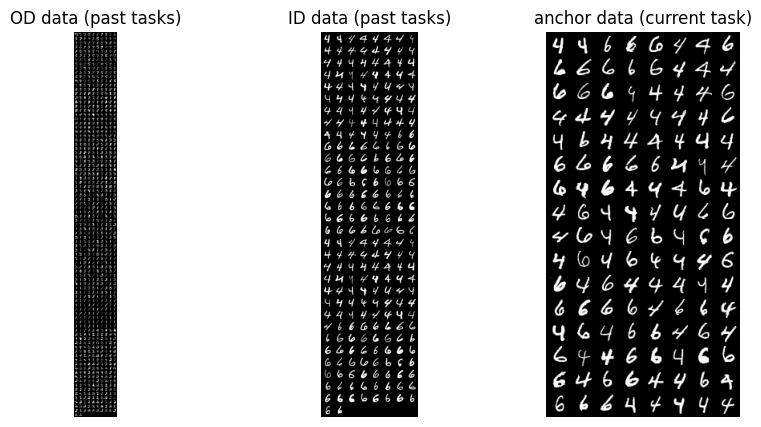

In [201]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(make_grid(X_od, nrow=10).permute(1,2,0))
axes[0].set_title("OD data (past tasks)")
axes[0].axis("off")

axes[1].imshow(make_grid(X_id, n_rows=10).permute(1,2,0))
axes[1].set_title("ID data (past tasks)");
axes[1].axis("off")


axes[2].imshow(make_grid(anchor_X, n_rows=10).permute(1,2,0))
axes[2].set_title("anchor data (current task)");
axes[2].axis("off");

In [202]:
len(anchor_X)

128

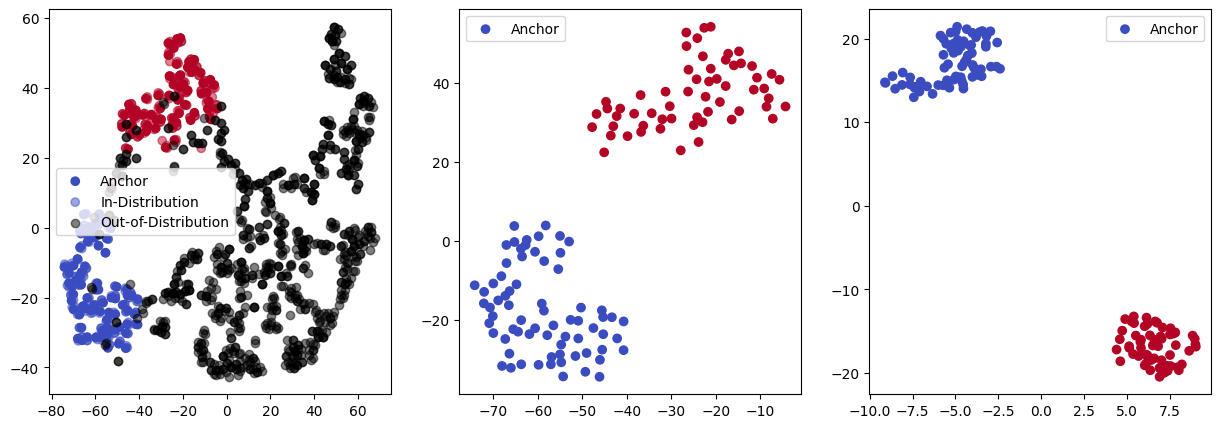

In [203]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

# Partial function for transform
transform = partial(contrastive_transform, agent.net, task_id)

# Process and plot data with OD
data_dict = apply_transform_to_data_dict(data_dict, transform)
data_dict = combined_tsne_transform(data_dict)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_data(data_dict, ax[0])

data_dict_wo_ood = deepcopy(data_dict)
del data_dict_wo_ood['OD']
del data_dict_wo_ood['ID']
plot_data(data_dict_wo_ood, ax[1])


data_dict_only_anchor = {
    "anchor": (anchor_X, anchor_y),
}
data_dict_only_anchor = apply_transform_to_data_dict(data_dict_only_anchor, transform)
data_dict_only_anchor = combined_tsne_transform(data_dict_only_anchor)
plot_data(data_dict_only_anchor, ax[2])

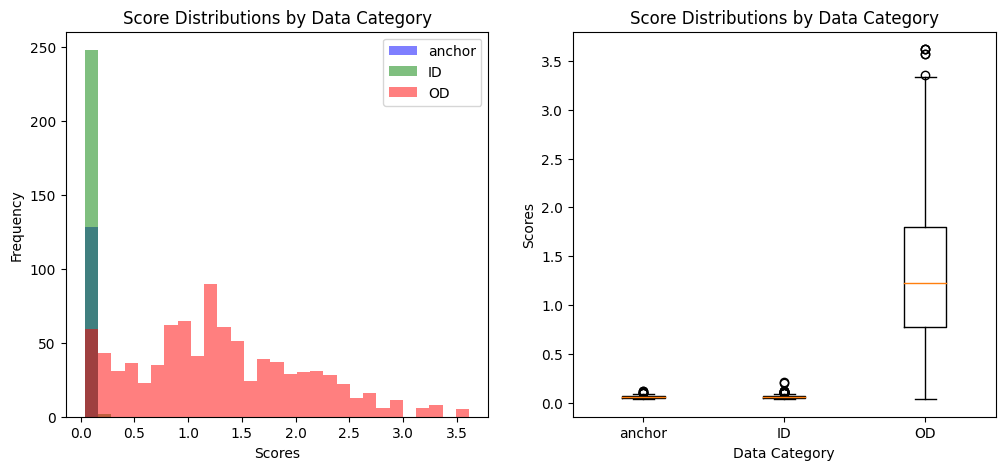

In [204]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

computer = partial(knn_distance, agent.net, task_id, anchor_X, num_neighbors=10)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_scores(data_dict, computer, ax[0])
plot_scores_box(data_dict, computer, ax[1])

In [205]:
X_od.shape

torch.Size([902, 1, 28, 28])

In [206]:
compute_ood_detection_quality(data_dict, computer, outlier_range=0.5)

[('anchor', (128,)), ('ID', (250,)), ('OD', (902,))]
No. of labeled ID data: 237
No. of labeled OD data: 915
Nominal Accuracy: 0.947
True Acc = Precision: 0.899


(array([[878,  24],
        [ 37, 213]]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]))

In [207]:
# viz the anchor and the OOD stuff that has been wrongly classified as ID.

Why is the query precision so bad?

__Hypothesis__
- the separation training isn't so good because it overfits to the replay buffer (overfitting problem)
    - DEBUNKED: test with all training data (so contains stuff it hasn't been trained on) and it still has good precision
- Separation training is bad on future data task that it has not seen before (generalization problem)
    - DEBUNKED: test with `agent.T=10` on future tasks
- Query data is too pathological
    - Verified: seems to be the case

__Fix ideas__
- Be hyper-conservative. Only accept data that has definitive answer.

## Test the query from other neighbors

In [208]:
fleet.communicate_round(task_id, communication_round=0) # send query to neighbors

In [209]:
qX, qY = get_all_incoming_query(fleet, agent_id)
qX.shape, qY.shape

(torch.Size([175, 1, 28, 28]), torch.Size([175]))

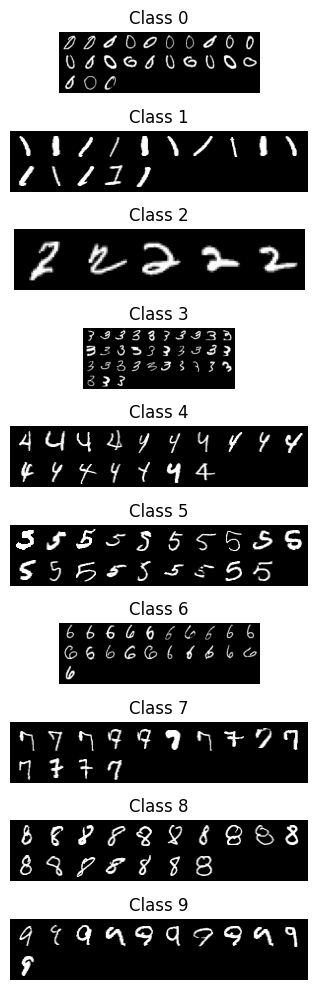

In [210]:
# visually verify that the qX, qY is correct
num_classes = len(qY.unique())
fig, axes = plt.subplots(num_classes, 1, figsize=(5, 10))
for i in qY.unique():
    axes[i].imshow(make_grid(qX[qY==i], nrow=10).permute(1,2,0))
    axes[i].set_title(f"Class {i}")
    axes[i].axis("off")
fig.tight_layout( )

In [211]:
anchor_X, anchor_y = agent.dataset.trainset[task_id].tensors
od_mask = agent.get_ood_data_helper(task_id, qY)
X_od, y_od = qX[od_mask], qY[od_mask]
X_id, y_id = qX[~od_mask], qY[~od_mask]

In [212]:
print('no. of OOD query:',len(X_od), '\nID query:', len(X_id))

no. of OOD query: 137 
ID query: 38


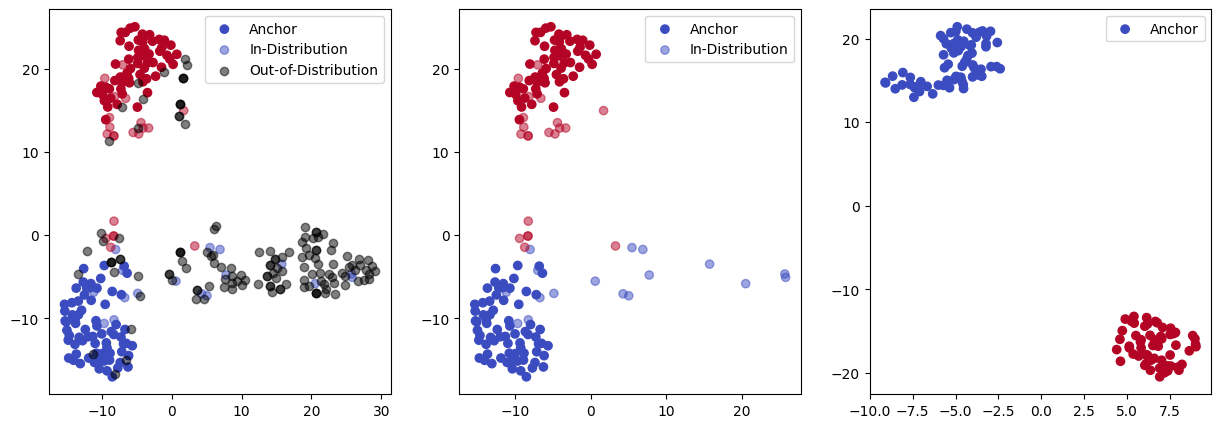

In [213]:

data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

# Partial function for transform
transform = partial(contrastive_transform, agent.net, task_id)

# Process and plot data with OD
data_dict = apply_transform_to_data_dict(data_dict, transform)
data_dict = combined_tsne_transform(data_dict)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_data(data_dict, ax[0])

data_dict_wo_ood = deepcopy(data_dict)
del data_dict_wo_ood['OD']
plot_data(data_dict_wo_ood, ax[1])


data_dict_only_anchor = {
    "anchor": (anchor_X, anchor_y),
}
data_dict_only_anchor = apply_transform_to_data_dict(data_dict_only_anchor, transform)
data_dict_only_anchor = combined_tsne_transform(data_dict_only_anchor)
plot_data(data_dict_only_anchor, ax[2])


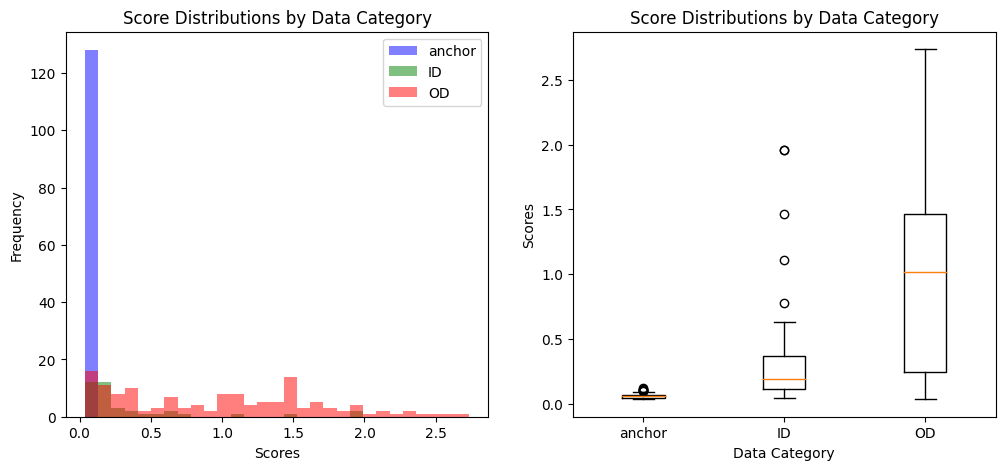

In [214]:
data_dict = {
    "anchor": (anchor_X, anchor_y),
    "OD": (X_od, y_od),
    "ID": (X_id, y_id),
}

computer = partial(knn_distance, agent.net, task_id, anchor_X, num_neighbors=10)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_scores(data_dict, computer, ax[0])
plot_scores_box(data_dict, computer, ax[1])

In [222]:
conf, labels, groundtruths = compute_ood_detection_quality(data_dict, computer, outlier_range=1.0)

[('anchor', (128,)), ('ID', (38,)), ('OD', (137,))]
No. of labeled ID data: 15
No. of labeled OD data: 160
Nominal Accuracy: 0.789
True Acc = Precision: 0.533


In [223]:
conf

array([[130,   7],
       [ 30,   8]])

In [224]:
# combine all X
Xs = []
for key in ['ID', 'OD']:
    X, _ = data_dict[key]
    Xs.append(X)
combined_X = torch.cat(Xs)
ood_wrongly_classified_as_id_X = combined_X[(labels == 1) & (groundtruths == 0)]
iid_wrongly_classified_as_od_X = combined_X[(labels == 0) & (groundtruths == 1)]
print(iid_wrongly_classified_as_od_X.shape)
print(ood_wrongly_classified_as_id_X.shape)

torch.Size([30, 1, 28, 28])
torch.Size([7, 1, 28, 28])


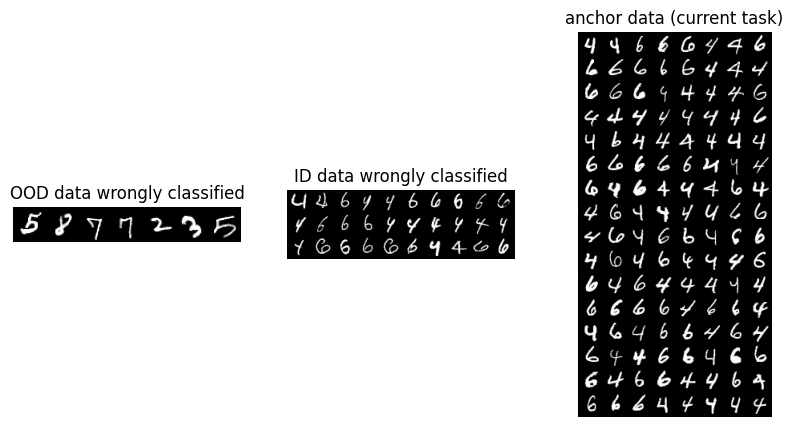

In [225]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(make_grid(ood_wrongly_classified_as_id_X, nrow=10).permute(1,2,0))
axes[0].set_title("OOD data wrongly classified") 
axes[0].axis("off")

axes[1].imshow(make_grid(iid_wrongly_classified_as_od_X, nrow=10).permute(1,2,0))
axes[1].set_title("ID data wrongly classified") 
axes[1].axis("off")


axes[2].imshow(make_grid(anchor_X, n_rows=10).permute(1,2,0))
axes[2].set_title("anchor data (current task)");
axes[2].axis("off");

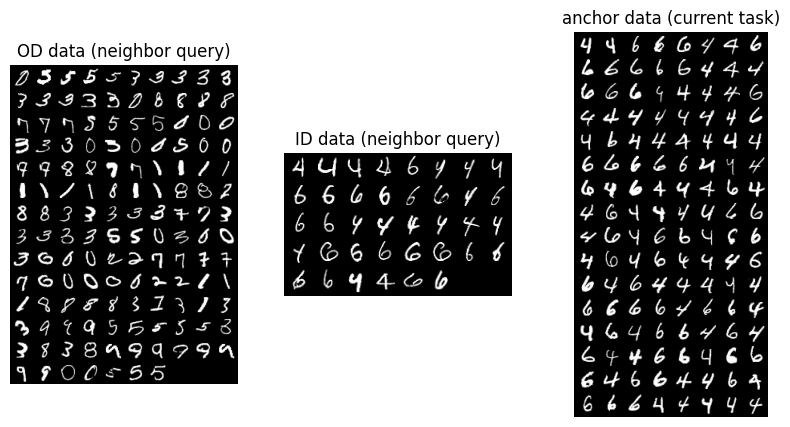

In [219]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(make_grid(X_od, nrow=10).permute(1,2,0))
axes[0].set_title("OD data (neighbor query)")
axes[0].axis("off")

axes[1].imshow(make_grid(X_id, n_rows=10).permute(1,2,0))
axes[1].set_title("ID data (neighbor query)");
axes[1].axis("off")


axes[2].imshow(make_grid(anchor_X, n_rows=10).permute(1,2,0))
axes[2].set_title("anchor data (current task)");
axes[2].axis("off");

In [33]:
# """
# https://en.wikipedia.org/wiki/Precision_and_recall
# We want to be more conservative in sharing data. We want to label outliers more
# -> in this case, more recall and less precision (NOT TRUE)
# """
# Compute KNN distances for each group
compute_ood_detection_quality(data_dict, computer)

[('anchor', (128,)), ('ID', (33,)), ('OD', (142,))]
No. of labeled OD data: 137
Accuracy: 0.743
Precision: 0.854
Recall: 0.824
F1 Score: 0.839
False Negative Rate: 0.176


Outlier range = 1.5
- [('anchor', (128,)), ('ID', (41,)), ('OD', (134,))]
- No. of labeled OD data: 126
- Accuracy: 0.714
- Precision: 0.833
- Recall: 0.784
- F1 Score: 0.808

Outlier range = 1.0 (more aggressively label outliers)
- [('anchor', (128,)), ('ID', (41,)), ('OD', (134,))]
- No. of labeled OD data: 132
- Accuracy: 0.691
- Precision: 0.803
- Recall: 0.791
- F1 Score: 0.797

Outlier range = 0.5
- [('anchor', (128,)), ('ID', (41,)), ('OD', (134,))]
- No. of labeled OD data: 137
- Accuracy: 0.697
- Precision: 0.796
- Recall: 0.813
- F1 Score: 0.804

Search engine
- naive embedding search
- prefilter with OOD thresholding + embedding search
- prefilter with OOD thresholding + task normalized distance + embedding search

## Naive Embedding Search

In [226]:
qX, qY = get_all_incoming_query(fleet, agent_id)

In [227]:
task_classes = agent.get_all_classes(task_id) 
task_classes

{3, 4, 5, 6, 7, 8, 9}

In [230]:
task_classes_tensor = torch.tensor(list(task_classes))
all_ood_mask = ~torch.isin(qY, task_classes_tensor)
qY_ood = qY[all_ood_mask]
len(qY), len(qY_ood)

(175, 43)

In [238]:
task_id

4

In [249]:
agent.agent.T = task_id + 1
sims, Xs, ys, tasks = agent.compute_similarity(qX)
sims.shape

torch.Size([175, 256])

In [250]:
X_neighbors, Y_neighbors, task_neighbors = agent.extract_topk_from_similarity(
            sims, Xs, ys, tasks,
            num_neighbors=5,
            candidate_tasks=None,
            map_to_globals=True,
        )
Y_neighbors.shape

torch.Size([175, 5])

In [251]:
"""
qY.shape = (N,)
Y_neighbors.shape = (N, num_neighbors)

compute the number of neighbors that are in the same class as qY

First, create a binary matrix of shape (N, num_classes)
where entry (i, j) is 1 if Y_neighbors[i, j] == qY[i] else 0
"""
same_class_matrix = (Y_neighbors == qY[:, None]).int()
# compute the accuracy as the sum divided by the matrix size
acc = same_class_matrix.sum() / same_class_matrix.numel()
print('acc', acc)

acc tensor(0.2526)


In [252]:
## NOTE: cheating filter qX, and qY to include only ID
qX_id, qY_id = qX[~all_ood_mask], qY[~all_ood_mask]
sims, Xs, ys, tasks = agent.compute_similarity(qX_id)
X_neighbors, Y_neighbors, task_neighbors = agent.extract_topk_from_similarity(
            sims, Xs, ys, tasks,
            num_neighbors=5,
            candidate_tasks=None,
            map_to_globals=True,
        )
same_class_matrix = (Y_neighbors == qY_id[:, None]).int()
# compute the accuracy as the sum divided by the matrix size
acc = same_class_matrix.sum() / same_class_matrix.numel()
print(same_class_matrix.shape)
print('acc', acc)

torch.Size([132, 5])
acc tensor(0.3348)


## OOD Thresholding + Embedding Search

In [254]:
qX, qY = get_all_incoming_query(fleet, agent_id)
n_filter_neighbors = task_id+1
# create a candidate_tasks tensor of shape (N, n_filter_neighbors)
candidate_tasks = np.ones((len(qY), n_filter_neighbors)) * -1
outlier_range = 0.

for t in range(task_id+1):
    anchor_X, anchor_y = agent.dataset.trainset[t].tensors
    anchor_y = get_global_labels(anchor_y, t, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
    task_classes = agent.get_task_class(t) 
    task_classes_tensor = torch.tensor(list(task_classes))
    all_ood_mask = ~torch.isin(qY, task_classes_tensor)
    qX_ood, qY_ood = qX[all_ood_mask], qY[all_ood_mask]
    qX_id, qY_id = qX[~all_ood_mask], qY[~all_ood_mask]

    data_dict = {
        "anchor": (anchor_X, anchor_y),
        "query": (qX, qY),
        "OD": (qX_ood, qY_ood),
        "ID": (qX_id, qY_id),
    }
    computer = partial(knn_distance, agent.net, t, anchor_X, num_neighbors=10)
    scores_dict = {}
    for key in ['anchor', 'ID', 'OD', 'query']:
        if key in data_dict:
            X, _ = data_dict[key]
            scores = computer(X)
            scores_dict[key] = scores

    _, t_upper_threshold = calculate_boxplot_outlier_thresholds(scores_dict['anchor'],
                                                            outlier_range=outlier_range)
    t_labels = scores_dict['query'] > t_upper_threshold
    t_iid = scores_dict['query'] <= t_upper_threshold
    candidate_tasks[t_iid, t] = t
    print(t, sum(t_iid), sum(t_labels))
    del data_dict['query']
    compute_ood_detection_quality(data_dict, computer, outlier_range=outlier_range)

0 5 170
[('anchor', (128,)), ('ID', (33,)), ('OD', (142,))]
No. of labeled ID data: 5
No. of labeled OD data: 170
Nominal Accuracy: 0.783
True Acc = Precision: 0.000
1 5 170
[('anchor', (128,)), ('ID', (34,)), ('OD', (141,))]
No. of labeled ID data: 5
No. of labeled OD data: 170
Nominal Accuracy: 0.811
True Acc = Precision: 0.600
2 4 171
[('anchor', (128,)), ('ID', (32,)), ('OD', (143,))]
No. of labeled ID data: 4
No. of labeled OD data: 171
Nominal Accuracy: 0.817
True Acc = Precision: 0.500
3 4 171
[('anchor', (128,)), ('ID', (50,)), ('OD', (125,))]
No. of labeled ID data: 4
No. of labeled OD data: 171
Nominal Accuracy: 0.714
True Acc = Precision: 0.500
4 8 167
[('anchor', (128,)), ('ID', (38,)), ('OD', (137,))]
No. of labeled ID data: 8
No. of labeled OD data: 167
Nominal Accuracy: 0.783
True Acc = Precision: 0.500


In [255]:
np.unique(candidate_tasks, return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.,  4.]), array([849,   5,   5,   4,   4,   8]))

In [273]:
# count the number of rows in candidate_tasks that are all -1
pred_ood = np.all(candidate_tasks == -1, axis=1)
qY_pred_iid = qY[~pred_ood]
print("No. of predicted OOD:", np.sum(pred_ood))
print("No. of predicted IID:", np.sum(~pred_ood))

No. of predicted OOD: 152
No. of predicted IID: 23


In [274]:
# # new def: hyper-conservative
# pred_id = np.sum(candidate_tasks != -1, axis=1) == 1
# pred_ood = ~pred_id
# print("No. of predicted OOD:", np.sum(pred_ood))
# print("No. of predicted IID:", np.sum(pred_id))

In [275]:
sims, Xs, ys, tasks = agent.compute_similarity(qX)
X_neighbors, Y_neighbors, task_neighbors = agent.extract_topk_from_similarity(
            sims, Xs, ys, tasks,
            num_neighbors=5,
            candidate_tasks=torch.tensor(candidate_tasks),
            map_to_globals=True,
        )
same_class_matrix = (Y_neighbors == qY[:, None]).int()
# compute the accuracy as the sum divided by the matrix size
acc = same_class_matrix.sum() / same_class_matrix.numel()
print('acc', acc)
np.unique(task_neighbors, return_counts=True)

acc tensor(0.1349)


(array([0, 1, 2, 3, 4]), array([ 25,  10,  20,  20, 800]))

In [276]:
same_class_matrix = (Y_neighbors[~pred_ood] == qY[~pred_ood, None]).int()
acc = same_class_matrix.sum() / same_class_matrix.numel()
print('acc', acc)

acc tensor(0.3043)


In [277]:
Y_neighbors[~pred_ood] == qY[~pred_ood, None]

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [F

In [278]:
print(Y_neighbors[~pred_ood] == qY[~pred_ood, None])

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [F

In [279]:
candidate_tasks[~pred_ood]

array([[-1., -1., -1.,  3., -1.],
       [-1., -1., -1.,  3., -1.],
       [-1.,  1., -1., -1.,  4.],
       [-1.,  1., -1., -1.,  4.],
       [-1., -1.,  2., -1., -1.],
       [-1., -1., -1.,  3., -1.],
       [-1., -1.,  2., -1., -1.],
       [-1.,  1., -1., -1.,  4.],
       [-1., -1., -1., -1.,  4.],
       [-1., -1.,  2., -1., -1.],
       [-1.,  1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [-1.,  1., -1., -1., -1.],
       [-1., -1., -1.,  3., -1.],
       [-1., -1., -1., -1.,  4.],
       [-1., -1.,  2., -1., -1.],
       [-1., -1., -1., -1.,  4.],
       [ 0., -1., -1., -1., -1.],
       [-1., -1., -1., -1.,  4.],
       [-1., -1., -1., -1.,  4.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.]])

In [262]:
qY[~pred_ood]

tensor([0, 3, 4, 4, 6, 0, 4, 4, 7, 6, 2, 4, 4, 3, 3, 7, 7, 6, 3, 3, 5, 3, 9])

In [263]:
Y_neighbors[~pred_ood]

tensor([[3, 3, 3, 3, 3],
        [8, 8, 8, 8, 8],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [6, 6, 6, 6, 6],
        [3, 3, 3, 3, 3],
        [9, 9, 9, 9, 9],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [6, 6, 6, 6, 6],
        [8, 8, 8, 8, 8],
        [7, 7, 7, 7, 7],
        [7, 7, 7, 7, 7],
        [4, 4, 4, 4, 4],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [9, 9, 9, 9, 9],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5],
        [7, 7, 7, 7, 7]])

In [264]:
qY.shape

torch.Size([175])

In [265]:
same_class_matrix = (Y_neighbors_iid== qY_pred_iid[:, None]).int()
# compute the accuracy as the sum divided by the matrix size
acc = same_class_matrix.sum() / same_class_matrix.numel()
print('acc', acc)

NameError: name 'Y_neighbors_iid' is not defined

In [ ]:
same_class_matrix.shape

In [ ]:
# count no. of non -1 in candidate_tasks
np.sum(candidate_tasks[~pred_ood] != -1)

In [ ]:
candidate_tasks.shape

In [ ]:
qY_pred_iid

In [ ]:
agent.dataset.class_sequence

In [ ]:
candidate_tasks[~pred_ood]

## Normalized Distance

task 0 [7, 5] num anchor 128 num ID 33 num OD 142
task 1 [8, 4] num anchor 128 num ID 34 num OD 141
task 2 [6, 9] num anchor 128 num ID 32 num OD 143
task 3 [8, 3] num anchor 128 num ID 50 num OD 125
task 4 [4, 6] num anchor 128 num ID 38 num OD 137


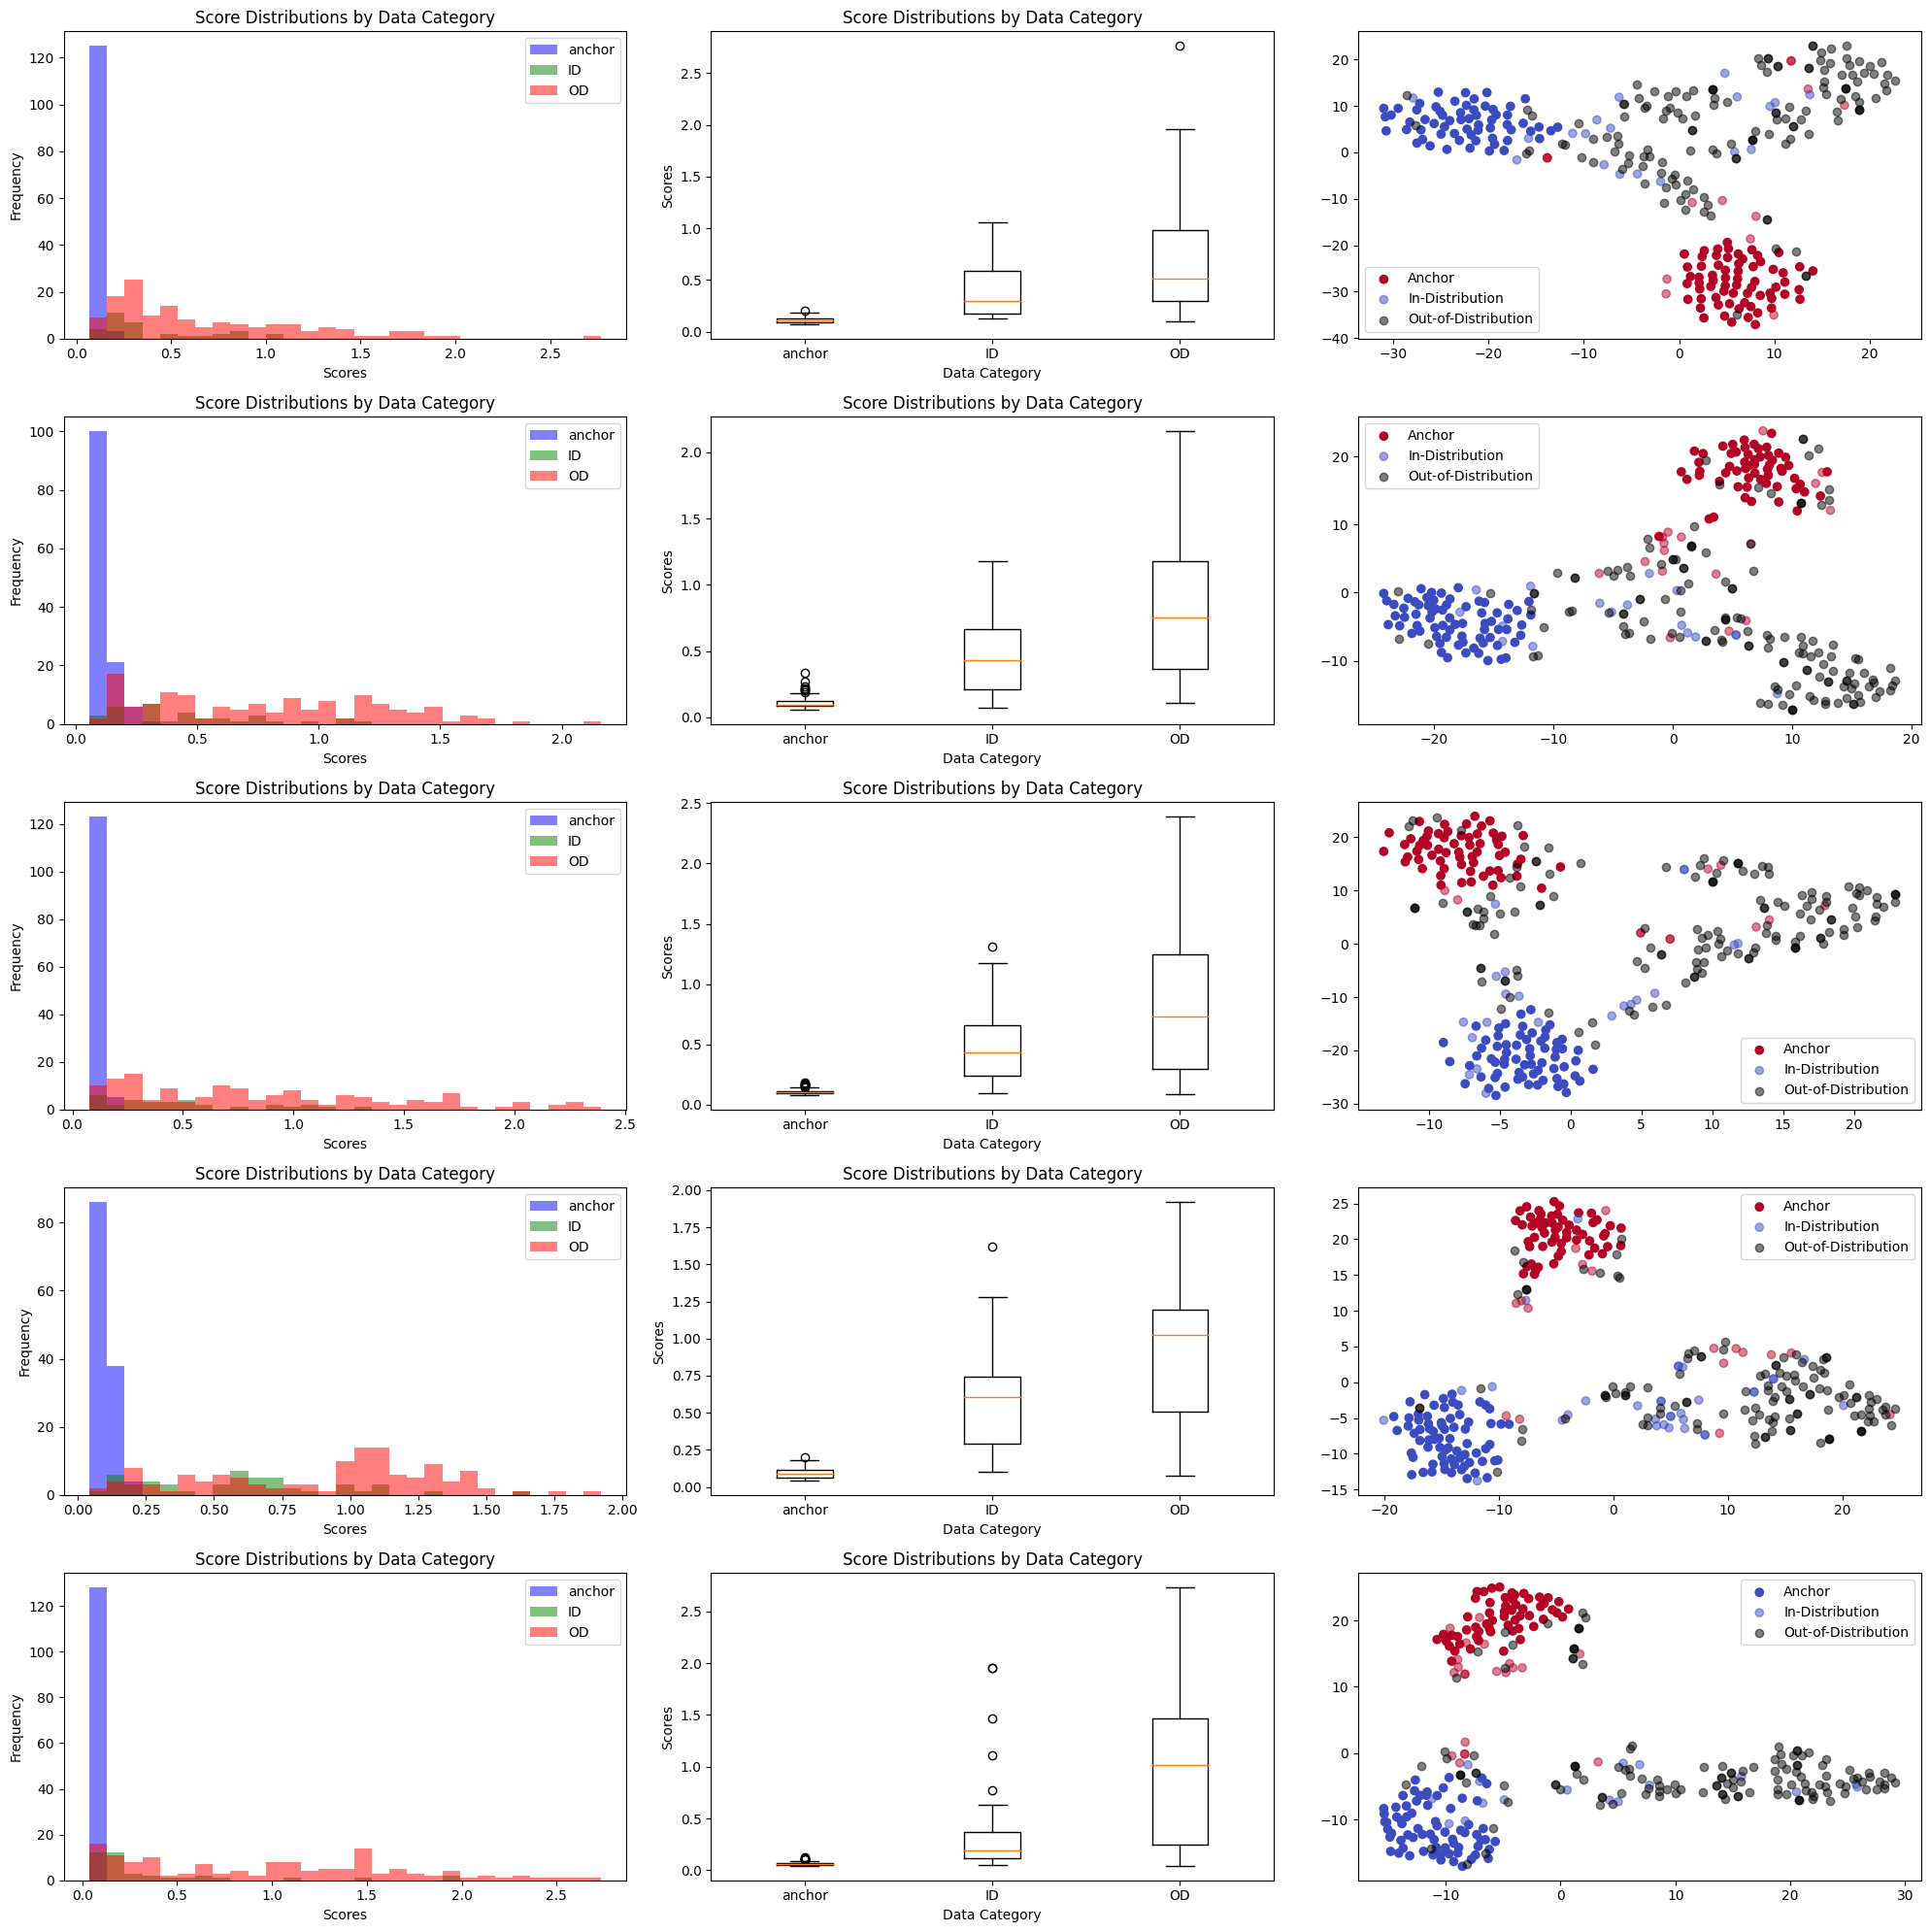

In [266]:
fig, ax = plt.subplots(task_id+1, 3, figsize=(20, 20))
for t in range(task_id+1):
    # anchor_X, anchor_y, _ = agent.agent.replay_buffers[t].tensors
    anchor_X, anchor_y = agent.dataset.trainset[t].tensors
    qX, qY = get_all_incoming_query(fleet, agent_id)
    task_classes = agent.get_task_class(t) 
    task_classes_tensor = torch.tensor(list(task_classes))
    all_ood_mask = ~torch.isin(qY, task_classes_tensor)
    qX_ood, qY_ood = qX[all_ood_mask], qY[all_ood_mask]
    qX_id, qY_id = qX[~all_ood_mask], qY[~all_ood_mask]
    anchor_y = get_global_labels(anchor_y, t, agent.dataset.class_sequence, agent.dataset.num_classes_per_task)
    data_dict = {
        "anchor": (anchor_X, anchor_y),
        "OD": (qX_ood, qY_ood),
        "ID": (qX_id, qY_id),
    }
    print('task', t, task_classes, 'num anchor', len(anchor_y), 'num ID', len(qY_id), 'num OD', len(qY_ood))

    computer = partial(knn_distance, agent.net, t, anchor_X, num_neighbors=10)
    plot_scores(data_dict, computer, ax[t, 0])
    plot_scores_box(data_dict, computer, ax[t, 1])


    # Partial function for transform
    transform = partial(contrastive_transform, agent.net, t)

    # Process and plot data with OD
    data_dict = apply_transform_to_data_dict(data_dict, transform)
    data_dict = combined_tsne_transform(data_dict)
    # del data_dict['OD']
    # del data_dict['ID']
    plot_data(data_dict, ax[t, 2])
fig.tight_layout()